In [1]:
import scipy.io as spio
import numpy as np

In [2]:
X = spio.loadmat(file_name='../data/bci-sample-data/x.mat')

In [3]:
Y = spio.loadmat(file_name='../data/bci-sample-data/y.mat')

In [4]:
Data = X['Intensification_Data']
SType = Y['Intensification_SType'].mean(axis=1)

In [5]:
# Normalizing input data
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [6]:
# Standardize/normalize train and test
X_norm = normalize(inputs=Data)

In [7]:
# Deviding the input data into train and validation
# 30 % of data is test and the rest train
length = int(X_norm.shape[0] * 0.3)
X_train_norm = X_norm[: -length]
X_valid_norm = X_norm[-length:]

In [8]:
Y_train = np.array(SType[ :-length], dtype=int)
Y_valid = np.array(SType[-length: ], dtype=int)

In [9]:
(X_train_norm.shape, X_train_norm.dtype, Y_train.shape, Y_train.dtype)

((4536, 192, 64), dtype('<f8'), (4536,), dtype('int64'))

### Hyperparameters

In [10]:
# Input data
# X_(5832, 192, 64): (n_trials, seq_len, n_channels), batch_size== n_trials
batch_size = X_train_norm.shape[0]// 100 # Batch size: number of trials
seq_len = X_train_norm.shape[1]          # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
# Y_(5832, 2): (n_trails, n_classes)
n_classes = Y_train.max() + 1

# Tweekable parameters
learning_rate = 0.001 #1e-3
epochs = 5 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

In [11]:
Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)

In [12]:
(Y_train_onehot.shape, Y_valid_onehot.shape, X_train_norm.shape, X_valid_norm.shape)

((4536, 2), (1944, 2), (4536, 192, 64), (1944, 192, 64))

# GPUs availability or CPU

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [14]:
#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')

# Convolutional Layers, FC Layer, and Output layer

In [16]:
# (batch, 192, 9) --> (batch, 91, 18)
out_conv = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=12, strides=2, 
                         padding='valid', activation = tf.nn.relu)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 91, 18) --> (batch, 91*18) --> (batch, 91*18*2)
# 91 * 18 = 728 + 910 = 1638 * 2 = 3276
in_fc = tf.reshape(out_conv, (-1, 91*18))
out_fc = tf.layers.dense(inputs=in_fc, units=91*18*2, activation=tf.nn.relu)
out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(in_fc.shape, out_fc.shape)

# (batch, 91*18*2) --> (batch, 2) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(logits.shape)

(?, 91, 18)
(?, 1638) (?, 3276)
(?, 2)


In [17]:
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [18]:
train_losses, valid_losses = [], []
train_acc_list, valid_acc_list = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over training minibatches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary of training minibatch
            feed = {inputs_:x, labels_:y, keep_prob_:keep_prob, learning_rate_:learning_rate}
            train_loss, _ , train_acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
            # Feed dictionary of validation full-batch 
            # no dropout/keep_prob; no learning rate/ no learning
            feed = {inputs_:X_valid_norm, labels_:Y_valid_onehot, keep_prob_:1.0}
            valid_loss, valid_acc = sess.run([cost, accuracy], feed_dict = feed)

            # Print at each iter/ epoch
            print("Epoch: {}/{}".format(e, epochs),
                  "Train loss: {:6f}".format(train_loss),
                  "Valid loss: {:.6f}".format(valid_loss),
                  "train acc: {:.6f}".format(train_acc),
                  "Valid acc: {:.6f}".format(valid_acc))

            # Ploting the learning curve for training and validation
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)

Epoch: 0/5 Train loss: 0.525077 Valid loss: 1.034006 train acc: 0.777778 Valid acc: 0.833333
Epoch: 0/5 Train loss: 0.924303 Valid loss: 1.386152 train acc: 0.844445 Valid acc: 0.733539
Epoch: 0/5 Train loss: 2.297767 Valid loss: 2.474142 train acc: 0.577778 Valid acc: 0.831276
Epoch: 0/5 Train loss: 2.124548 Valid loss: 2.597000 train acc: 0.822222 Valid acc: 0.832819
Epoch: 0/5 Train loss: 1.947193 Valid loss: 1.793211 train acc: 0.844445 Valid acc: 0.832304
Epoch: 0/5 Train loss: 0.968336 Valid loss: 0.980193 train acc: 0.844445 Valid acc: 0.808642
Epoch: 0/5 Train loss: 0.990649 Valid loss: 2.077199 train acc: 0.711111 Valid acc: 0.620370
Epoch: 0/5 Train loss: 1.069281 Valid loss: 2.723554 train acc: 0.644444 Valid acc: 0.594136
Epoch: 0/5 Train loss: 3.508722 Valid loss: 1.882537 train acc: 0.511111 Valid acc: 0.830761
Epoch: 0/5 Train loss: 3.988661 Valid loss: 2.423728 train acc: 0.844445 Valid acc: 0.833333
Epoch: 0/5 Train loss: 3.121867 Valid loss: 2.371788 train acc: 0.8222

Epoch: 0/5 Train loss: 0.533895 Valid loss: 0.480434 train acc: 0.711111 Valid acc: 0.832819
Epoch: 0/5 Train loss: 0.485373 Valid loss: 0.469425 train acc: 0.755556 Valid acc: 0.833333
Epoch: 0/5 Train loss: 0.399663 Valid loss: 0.491745 train acc: 0.822222 Valid acc: 0.833333
Epoch: 0/5 Train loss: 0.866024 Valid loss: 0.505400 train acc: 0.844445 Valid acc: 0.833333
Epoch: 0/5 Train loss: 0.678372 Valid loss: 0.505332 train acc: 0.822222 Valid acc: 0.833333
Epoch: 0/5 Train loss: 0.568295 Valid loss: 0.495179 train acc: 0.844445 Valid acc: 0.833333
Epoch: 0/5 Train loss: 0.583891 Valid loss: 0.482408 train acc: 0.822222 Valid acc: 0.833333
Epoch: 0/5 Train loss: 0.415376 Valid loss: 0.475321 train acc: 0.844445 Valid acc: 0.833333
Epoch: 0/5 Train loss: 0.444744 Valid loss: 0.471488 train acc: 0.822222 Valid acc: 0.833333
Epoch: 0/5 Train loss: 0.463257 Valid loss: 0.468982 train acc: 0.822222 Valid acc: 0.832819
Epoch: 0/5 Train loss: 0.398746 Valid loss: 0.467596 train acc: 0.8444

Epoch: 1/5 Train loss: 0.394760 Valid loss: 0.416956 train acc: 0.822222 Valid acc: 0.837448
Epoch: 1/5 Train loss: 0.426130 Valid loss: 0.416529 train acc: 0.822222 Valid acc: 0.836420
Epoch: 1/5 Train loss: 0.391519 Valid loss: 0.416663 train acc: 0.844445 Valid acc: 0.838992
Epoch: 1/5 Train loss: 0.365887 Valid loss: 0.416358 train acc: 0.866667 Valid acc: 0.840535
Epoch: 1/5 Train loss: 0.415813 Valid loss: 0.416155 train acc: 0.844445 Valid acc: 0.839506
Epoch: 1/5 Train loss: 0.406594 Valid loss: 0.418770 train acc: 0.844445 Valid acc: 0.842078
Epoch: 1/5 Train loss: 0.393599 Valid loss: 0.421191 train acc: 0.888889 Valid acc: 0.841049
Epoch: 1/5 Train loss: 0.502193 Valid loss: 0.422879 train acc: 0.755556 Valid acc: 0.838477
Epoch: 1/5 Train loss: 0.401311 Valid loss: 0.426913 train acc: 0.822222 Valid acc: 0.839506
Epoch: 1/5 Train loss: 0.454183 Valid loss: 0.430603 train acc: 0.844445 Valid acc: 0.841564
Epoch: 1/5 Train loss: 0.421041 Valid loss: 0.425896 train acc: 0.8222

Epoch: 2/5 Train loss: 0.522864 Valid loss: 0.435202 train acc: 0.822222 Valid acc: 0.843621
Epoch: 2/5 Train loss: 0.488191 Valid loss: 0.440966 train acc: 0.866667 Valid acc: 0.844136
Epoch: 2/5 Train loss: 0.467571 Valid loss: 0.440104 train acc: 0.844445 Valid acc: 0.843621
Epoch: 2/5 Train loss: 0.495109 Valid loss: 0.428657 train acc: 0.822222 Valid acc: 0.843621
Epoch: 2/5 Train loss: 0.453025 Valid loss: 0.415347 train acc: 0.844445 Valid acc: 0.848765
Epoch: 2/5 Train loss: 0.321887 Valid loss: 0.407767 train acc: 0.844445 Valid acc: 0.850309
Epoch: 2/5 Train loss: 0.623335 Valid loss: 0.399786 train acc: 0.755556 Valid acc: 0.856996
Epoch: 2/5 Train loss: 0.303038 Valid loss: 0.399934 train acc: 0.866667 Valid acc: 0.855967
Epoch: 2/5 Train loss: 0.317140 Valid loss: 0.398768 train acc: 0.866667 Valid acc: 0.855453
Epoch: 2/5 Train loss: 0.292092 Valid loss: 0.398598 train acc: 0.866667 Valid acc: 0.855967
Epoch: 2/5 Train loss: 0.473989 Valid loss: 0.397622 train acc: 0.8444

Epoch: 3/5 Train loss: 0.337180 Valid loss: 0.408408 train acc: 0.866667 Valid acc: 0.844136
Epoch: 3/5 Train loss: 0.383322 Valid loss: 0.414225 train acc: 0.866667 Valid acc: 0.846708
Epoch: 3/5 Train loss: 0.384354 Valid loss: 0.417383 train acc: 0.800000 Valid acc: 0.847222
Epoch: 3/5 Train loss: 0.380602 Valid loss: 0.420915 train acc: 0.822222 Valid acc: 0.846708
Epoch: 3/5 Train loss: 0.403045 Valid loss: 0.418156 train acc: 0.822222 Valid acc: 0.848765
Epoch: 3/5 Train loss: 0.685714 Valid loss: 0.396471 train acc: 0.822222 Valid acc: 0.851852
Epoch: 3/5 Train loss: 0.453856 Valid loss: 0.386160 train acc: 0.800000 Valid acc: 0.859568
Epoch: 3/5 Train loss: 0.343422 Valid loss: 0.383219 train acc: 0.866667 Valid acc: 0.858025
Epoch: 3/5 Train loss: 0.362785 Valid loss: 0.381900 train acc: 0.844445 Valid acc: 0.860597
Epoch: 3/5 Train loss: 0.410920 Valid loss: 0.380479 train acc: 0.866667 Valid acc: 0.859568
Epoch: 3/5 Train loss: 0.372786 Valid loss: 0.371138 train acc: 0.8000

Epoch: 4/5 Train loss: 0.429835 Valid loss: 0.415274 train acc: 0.800000 Valid acc: 0.854938
Epoch: 4/5 Train loss: 0.372107 Valid loss: 0.428092 train acc: 0.822222 Valid acc: 0.852366
Epoch: 4/5 Train loss: 0.608827 Valid loss: 0.395780 train acc: 0.844445 Valid acc: 0.858025
Epoch: 4/5 Train loss: 0.499689 Valid loss: 0.377474 train acc: 0.755556 Valid acc: 0.858025
Epoch: 4/5 Train loss: 0.360341 Valid loss: 0.369083 train acc: 0.844445 Valid acc: 0.864197
Epoch: 4/5 Train loss: 0.361046 Valid loss: 0.366419 train acc: 0.822222 Valid acc: 0.867798
Epoch: 4/5 Train loss: 0.408765 Valid loss: 0.367051 train acc: 0.800000 Valid acc: 0.866769
Epoch: 4/5 Train loss: 0.324230 Valid loss: 0.368067 train acc: 0.822222 Valid acc: 0.863683
Epoch: 4/5 Train loss: 0.261542 Valid loss: 0.372701 train acc: 0.888889 Valid acc: 0.858539
Epoch: 4/5 Train loss: 0.222159 Valid loss: 0.383053 train acc: 0.933333 Valid acc: 0.856481
Epoch: 4/5 Train loss: 0.299087 Valid loss: 0.395281 train acc: 0.8444

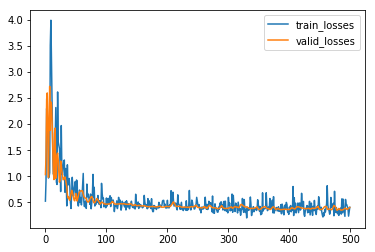

In [19]:
import matplotlib.pyplot as mplot

mplot.plot(train_losses, label='train_losses')
mplot.plot(valid_losses, label='valid_losses')
mplot.legend()
mplot.show()

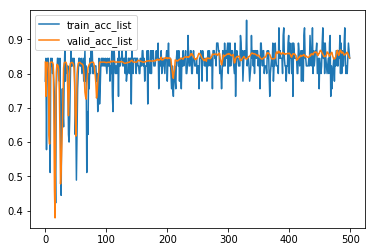

In [20]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc_list, label='train_acc_list')
mplot.plot(valid_acc_list, label='valid_acc_list')
mplot.legend()
mplot.show()